**Training and validation summary over the 5th experiment with 50 epochs**: 
this project is a version with 50 epochs of the best model achieved.


- **Model 5**: vgg19 pretrained + dropout(0.25) + conv2d(512) + conv2d(256) + pooling + dropout(0.25) + flatten() + dense(512) + dropout(0.5) + dense(11), input_shape = (224, 224, 3):
  - **Adam Optimizer**
   - Epoch 1/50 -> loss: 1.9654 - accuracy: 0.3066 - val_loss: 1.6964 - val_accuracy: 0.4331
   - Epoch 2/50 -> loss: 1.5669 - accuracy: 0.4609 - val_loss: 1.4158 - val_accuracy: 0.5211
   - ...
   - Epoch 49/50 -> loss: 0.9174 - accuracy: 0.6937 - val_loss: 1.1166 - val_accuracy: 0.6279
   - Epoch 50/50 -> loss: 0.9105 - accuracy: 0.6954 - val_loss: 1.1587 - val_accuracy: 0.6381

  - **SGD Optimizer**
    - Epoch 1/50 -> loss: 2.2986 - accuracy: 0.1687 - val_loss: 2.0662 - val_accuracy: 0.2791
    - Epoch 2/50 -> loss: 2.0133 - accuracy: 0.2797 - val_loss: 1.8038 - val_accuracy: 0.3532
    - ...
    - Epoch 49/50 -> loss: 1.0864 - accuracy: 0.6263 - val_loss: 1.1733 - val_accuracy: 0.6017
    - Epoch 50/50 -> loss: 1.0945 - accuracy: 0.6257 - val_loss: 1.0791 - val_accuracy: 0.6163




In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Mar 13 23:17:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    50W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# import section
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D, Flatten, Dense, Dropout, Conv2D, Input, Activation
import matplotlib.pyplot as plt
import numpy as np
from keras import optimizers

# versions 
print("Tensorflow version %s" %tf.__version__)
print("Keras version %s" %keras.__version__)

Tensorflow version 2.11.0
Keras version 2.11.0


In [ ]:
# Dataset, Preprocessing & Data Augmentation
import os
from keras.applications.vgg19 import preprocess_input as vgg_preprocess
training = '/content/drive/MyDrive/VISIOPE/Dataset/train/'
testing = '/content/drive/MyDrive/VISIOPE/Dataset/test/'
validating = '/content/drive/MyDrive/VISIOPE/Dataset/valid/'

batch_size = 32
target_size = (224, 224) 

# Preprocessing & Data Augmentation 
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255, 
    shear_range = 0.2, #proposed by paper 
    fill_mode = 'nearest', #proposed by paper
    zoom_range=0.2, #proposed by paper
    rotation_range=40, #proposed by paper
    width_shift_range=0.2, #proposed by paper
    height_shift_range=0.2, #proposed by paper
    horizontal_flip=True, #proposed by paper
    preprocessing_function=vgg_preprocess  #convert the input images from RGB to BGR, then will zero-center each color channel with respect to the ImageNet dataset
    )

# data generator for training data
train_generator = datagen.flow_from_directory(
    directory=training,
    target_size= target_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    )

# data generator for testing data
test_generator = datagen.flow_from_directory(
    directory=testing,
    target_size=target_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
)

# data generator for validating data
valid_generator = datagen.flow_from_directory(
    directory=validating,
    target_size=target_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
)

num_samples = train_generator.n
num_classes = train_generator.num_classes
input_shape = train_generator.image_shape
classnames = [k for k, v in train_generator.class_indices.items()]

print()
print("Image input %s" %str(input_shape))
print()
print("Classes: %r" %classnames)
print()
print('Loaded %d training samples from %d classes.' %(num_samples,num_classes))
print('Loaded %d testing samples from %d classes.' %(test_generator.n,test_generator.num_classes))
print('Loaded %d validating samples from %d classes.' %(valid_generator.n,valid_generator.num_classes))

Found 6510 images belonging to 11 classes.
Found 1411 images belonging to 11 classes.
Found 1398 images belonging to 11 classes.

Image input (224, 224, 3)

Classes: ['creamy_paste', 'diced', 'floured', 'grated', 'juiced', 'jullienne', 'mixed', 'other', 'peeled', 'sliced', 'whole']

Loaded 6510 training samples from 11 classes.
Loaded 1411 testing samples from 11 classes.
Loaded 1398 validating samples from 11 classes.


In [ ]:
# Getting the VGG19 standard model pretrained on imagenet 
from tensorflow.keras.applications import vgg19

def get_vgg19_base_model(input_shape):

    # load VGG19 model without the final dense layers 
    vgg19_base_model = vgg19.VGG19(include_top= False, weights = 'imagenet', input_shape = input_shape)
    
    return vgg19_base_model

In [ ]:
# Freeze the vgg19 base model

# function to freeze layers
def freeze_layers(start_freeze, end_freeze):
  vgg19_frozen = get_vgg19_base_model(input_shape)
  count = 0
  for layer in vgg19_frozen.layers[:]:
    count += 1
    if (count >= start_freeze and count <= end_freeze):
      layer.trainable = False
  return vgg19_frozen

# Freeze layers from start_freeze to end_freeze (first layer: 1, last layer: 22)
start_freeze = 1 
end_freeze = 22
# note: we are freezing the whole model. In this way we are using the pretrained version of vgg19 on ImageNet, without changing the weights during training. 

# call freezing function
vgg19_frozen = freeze_layers(start_freeze = start_freeze, end_freeze = end_freeze)

# check that layers are actually frozen
check = 0
count = 0
print()
for layer in vgg19_frozen.layers[:]:
  count += 1
  print(count, layer, layer.trainable)
  if (count >= start_freeze and count <= end_freeze):
    if layer.trainable == False:
      check = 1
    else:
      check = 0
print()
print()
if check == 1:
  print('Layers from %d to %d have been correctly frozen' %(start_freeze,end_freeze))     

80134624/80134624 [==============================] - 0s 0us/step

1 <keras.engine.input_layer.InputLayer object at 0x7fc604336fd0> False
2 <keras.layers.convolutional.conv2d.Conv2D object at 0x7fc5fd75bcd0> False
3 <keras.layers.convolutional.conv2d.Conv2D object at 0x7fc5fd7cc610> False
4 <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7fc5fd760f10> False
5 <keras.layers.convolutional.conv2d.Conv2D object at 0x7fc5fd70bc10> False
6 <keras.layers.convolutional.conv2d.Conv2D object at 0x7fc5fc85f190> False
7 <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7fc5fcd8f1c0> False
8 <keras.layers.convolutional.conv2d.Conv2D object at 0x7fc5fc85fdc0> False
9 <keras.layers.convolutional.conv2d.Conv2D object at 0x7fc5fc86a280> False
10 <keras.layers.convolutional.conv2d.Conv2D object at 0x7fc5fc86aeb0> False
11 <keras.layers.convolutional.conv2d.Conv2D object at 0x7fc5fc86e190> False
12 <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7fc5fc875dc0> False
13 

In [ ]:
# modified model - this one corresponds to the best model achieved. In particular it is the 5-th experiment.
def VGG19_mod(input_shape, num_classes, optimizer, vgg19_frozen):
    
    # create modified model
    vgg19_modified = Sequential()

    # add the vgg19 base model with all layers frozen
    vgg19_modified.add(vgg19_frozen)

    # add additional layers to improve accuracy
    vgg19_modified.add(Dropout(0.25)) 
    vgg19_modified.add(Conv2D(filters=512, kernel_size=(3,3), activation="relu"))
    vgg19_modified.add(Conv2D(filters=256, kernel_size=(3,3), activation="relu"))
    vgg19_modified.add(MaxPooling2D(pool_size = (2,2)))
    vgg19_modified.add(Dropout(0.25))

    # fully connected block
    vgg19_modified.add(Flatten()) 
    vgg19_modified.add(Dense(512, activation="relu"))
    vgg19_modified.add(Dropout(0.5))
    vgg19_modified.add(Dense(num_classes, activation='softmax')) #output layer
    
    # compile the model 
    vgg19_modified.compile(loss=keras.losses.categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])

    return vgg19_modified

# optimizers 
opt1 = keras.optimizers.Adam(learning_rate=0.001)
opt2 = keras.optimizers.SGD(learning_rate=0.01) 

# call the modified model...
vgg19_modified_1 = VGG19_mod(input_shape, num_classes, opt1, vgg19_frozen) #... with Adam optimizer
vgg19_modified_1.summary()

vgg19_modified_2 = VGG19_mod(input_shape, num_classes, opt2, vgg19_frozen) #... with SGD optimizer

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 dropout (Dropout)           (None, 7, 7, 512)         0         
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 512)         2359808   
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 3, 256)         1179904   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 1, 256)        0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 1, 1, 256)         0         
                                                        

In [ ]:
# Training and Validation (adam optimizer)
steps_per_epoch=train_generator.samples//train_generator.batch_size
val_steps=valid_generator.samples//valid_generator.batch_size
epochs = 50

try: 
    history1 = vgg19_modified_1.fit(train_generator, 
                  epochs=epochs, 
                  verbose = 1, 
                  steps_per_epoch = steps_per_epoch,
                  validation_data = valid_generator,
                  validation_steps = val_steps,
                 )
except KeyboardInterrupt:
    pass

Epoch 1/50
203/203 [==============================] - 2324s 11s/step - loss: 1.9654 - accuracy: 0.3066 - val_loss: 1.6964 - val_accuracy: 0.4331
Epoch 2/50
203/203 [==============================] - 135s 667ms/step - loss: 1.5669 - accuracy: 0.4609 - val_loss: 1.4158 - val_accuracy: 0.5211
Epoch 3/50
203/203 [==============================] - 135s 665ms/step - loss: 1.4493 - accuracy: 0.5019 - val_loss: 1.3735 - val_accuracy: 0.5356
Epoch 4/50
203/203 [==============================] - 135s 666ms/step - loss: 1.3811 - accuracy: 0.5400 - val_loss: 1.3018 - val_accuracy: 0.5531
Epoch 5/50
203/203 [==============================] - 136s 668ms/step - loss: 1.3196 - accuracy: 0.5562 - val_loss: 1.2642 - val_accuracy: 0.5778
Epoch 6/50
203/203 [==============================] - 135s 667ms/step - loss: 1.2698 - accuracy: 0.5732 - val_loss: 1.3883 - val_accuracy: 0.5298
Epoch 7/50
203/203 [==============================] - 135s 663ms/step - loss: 1.2475 - accuracy: 0.5840 - val_loss: 1.3490 - 

In [ ]:
# Training and Validation (sgd optimizer) 
steps_per_epoch=train_generator.samples//train_generator.batch_size
val_steps=valid_generator.samples//valid_generator.batch_size
epochs = 50
try: 
   history2 = vgg19_modified_2.fit(train_generator, 
                 epochs=epochs, 
                 verbose = 1, 
                 steps_per_epoch = steps_per_epoch,
                 validation_data = valid_generator,
                 validation_steps = val_steps,
                )
except KeyboardInterrupt:
   pass

Epoch 1/50
203/203 [==============================] - 139s 676ms/step - loss: 2.2986 - accuracy: 0.1687 - val_loss: 2.0662 - val_accuracy: 0.2791
Epoch 2/50
203/203 [==============================] - 137s 674ms/step - loss: 2.0133 - accuracy: 0.2797 - val_loss: 1.8038 - val_accuracy: 0.3532
Epoch 3/50
203/203 [==============================] - 137s 675ms/step - loss: 1.8392 - accuracy: 0.3479 - val_loss: 1.7243 - val_accuracy: 0.3634
Epoch 4/50
203/203 [==============================] - 138s 678ms/step - loss: 1.7613 - accuracy: 0.3648 - val_loss: 1.5726 - val_accuracy: 0.4564
Epoch 5/50
203/203 [==============================] - 137s 675ms/step - loss: 1.6749 - accuracy: 0.4083 - val_loss: 1.4951 - val_accuracy: 0.4644
Epoch 6/50
203/203 [==============================] - 137s 677ms/step - loss: 1.6316 - accuracy: 0.4231 - val_loss: 1.4941 - val_accuracy: 0.4876
Epoch 7/50
203/203 [==============================] - 138s 678ms/step - loss: 1.5908 - accuracy: 0.4409 - val_loss: 1.4027 -

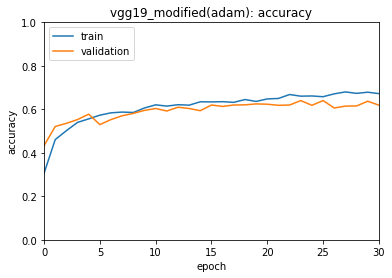

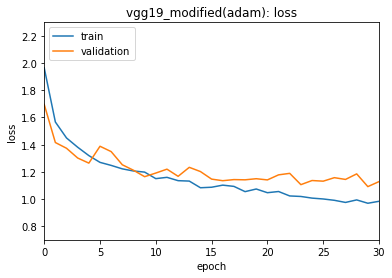

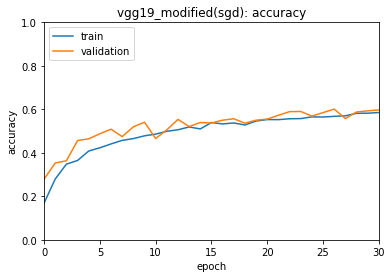

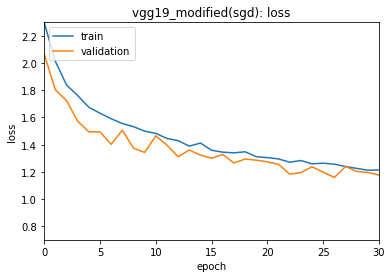

In [ ]:
# Check performance in terms of loss function and accuracy 

import matplotlib.pyplot as plt

# vgg19_modified_1 - summarize history for accuracy 
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('vgg19_modified(adam): accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(0.0,1.0)
plt.xlim(0.0,30.0)
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# vgg19_modified_1 - summarize history for loss
plt.plot((history1.history['loss']))
plt.plot((history1.history['val_loss']))
plt.title('vgg19_modified(adam): loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim(0.7,2.3)
plt.xlim(0.0,30.0)
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# vgg19_modified_2 - summarize history for accuracy 
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('vgg19_modified(sgd): accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(0.0,1.0)
plt.xlim(0.0,30.0)
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# vgg19_modified_2 - summarize history for loss
plt.plot((history2.history['loss']))
plt.plot((history2.history['val_loss']))
plt.title('vgg19_modified(sgd): loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim(0.7,2.3)
plt.xlim(0.0,30.0)
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# Evaluation
score_1 = vgg19_modified_1.evaluate(x = test_generator, verbose = 1) 
score_2 = vgg19_modified_2.evaluate(x = test_generator, verbose = 1)

print()
print('Model compiled with Adam - Test loss:', score_1[0]) 
print('Model compiled with Adam - Test accuracy:', score_1[1])
#print()
print('Model compiled with SGD - Test loss:', score_2[0]) 
print('Model compiled with SGD - Test accuracy:', score_2[1])

45/45 [==============================] - 25s 546ms/step - loss: 1.1185 - accuracy: 0.6116

Model compiled with Adam - Test loss: 1.1425963640213013
Model compiled with Adam - Test accuracy: 0.6335932016372681
Model compiled with SGD - Test loss: 1.1185142993927002
Model compiled with SGD - Test accuracy: 0.6116229891777039


In [ ]:
# Prediction

predictions_1 = vgg19_modified_1.predict(test_generator, verbose=1, steps=test_generator.n//test_generator.batch_size+1) #model compiled with adam
predictions_2 = vgg19_modified_2.predict(test_generator, verbose=1, steps=test_generator.n//test_generator.batch_size+1) #model compiled with sgd

45/45 [==============================] - 25s 551ms/step


Model compiled with Adam - Classification Report
              precision    recall  f1-score   support

creamy_paste      0.667     0.532     0.592        94
       diced      0.522     0.821     0.638       117
     floured      0.621     0.726     0.669       124
      grated      0.692     0.675     0.684       120
      juiced      0.723     0.842     0.778       133
   jullienne      0.705     0.710     0.707       131
       mixed      0.813     0.952     0.877       105
       other      0.431     0.242     0.310       128
      peeled      0.609     0.602     0.606        88
      sliced      0.484     0.551     0.516       196
       whole      0.724     0.406     0.520       175

    accuracy                          0.627      1411
   macro avg      0.635     0.642     0.627      1411
weighted avg      0.629     0.627     0.616      1411


Model compiled with SGD - Classification Report
              precision    recall  f1-score   support

creamy_paste      0.590     0.628 

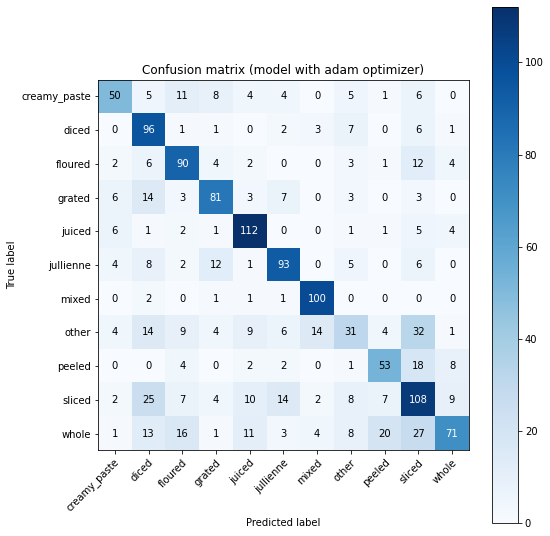

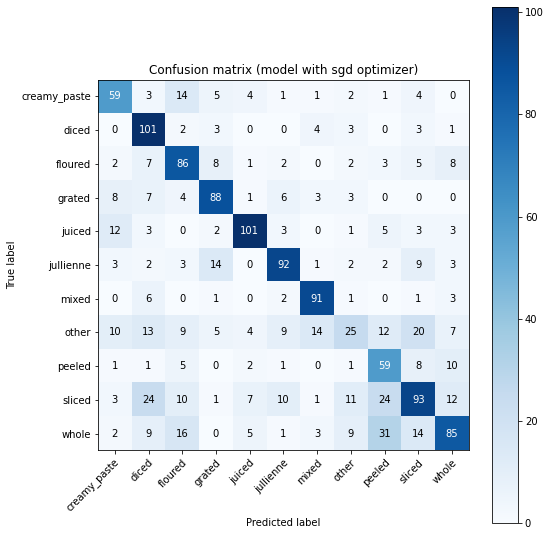

In [ ]:
# Test results

import sklearn.metrics 
from sklearn.metrics import classification_report, confusion_matrix

# All classes
classes = ['creamy_paste', 'diced', 'floured', 'grated', 'juiced', 'jullienne', 'mixed', 'other', 'peeled', 'sliced', 'whole']

# True labels for test images
y_test = test_generator.classes[test_generator.index_array] 

# Predicted labels on test images
y_pred_1 = np.argmax(predictions_1, axis=-1) 
y_pred_2 = np.argmax(predictions_2, axis=-1)

# Classification report
print('Model compiled with Adam - Classification Report')
print(classification_report(y_true=y_test, y_pred=y_pred_1, labels=None, target_names=classes, digits=3))
print()
print('Model compiled with SGD - Classification Report')
print(classification_report(y_test, y_pred_2, labels=None, target_names=classes, digits=3))

# Confusion matrices
conf_matrix_1 = confusion_matrix(y_test, y_pred_1)
conf_matrix_2 = confusion_matrix(y_test, y_pred_2)

# Plot confusion matrix 1
fig1, axes1 = plt.subplots()
im1 = axes1.imshow(conf_matrix_1, interpolation='nearest', cmap=plt.cm.Blues)
axes1.figure.colorbar(im1, ax=axes1)
axes1.figure.set_size_inches(8,8)

# Show all ticks and labels
axes1.set(xticks=np.arange(conf_matrix_1.shape[1]),
        yticks=np.arange(conf_matrix_1.shape[0]),
        xticklabels=classes, yticklabels=classes,
        title='Confusion matrix (model with adam optimizer)',
        ylabel='True label',
        xlabel='Predicted label')

axes1.set_ylim(bottom=len(classes)-0.5, top=-0.5)
plt.setp(axes1.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

# Fill confusion matrix
fmt = 'd' 
th = conf_matrix_1.max() / 2. #threshold used to assign colors to the text inside the conf matrix in order to display it better.

for i in range(conf_matrix_1.shape[0]):
    for j in range(conf_matrix_1.shape[1]):
        axes1.text(j, i, format(conf_matrix_1[i, j], fmt),
                ha="center", va="center",
                color="white" if conf_matrix_1[i, j] > th else "black")
fig1.tight_layout()

# Plot confusion matrix 2

fig2, axes2 = plt.subplots()
im2 = axes2.imshow(conf_matrix_2, interpolation='nearest', cmap=plt.cm.Blues)
axes2.figure.colorbar(im2, ax=axes2)
axes2.figure.set_size_inches(8,8)

# Show all ticks and labels
axes2.set(xticks=np.arange(conf_matrix_2.shape[1]),
       yticks=np.arange(conf_matrix_2.shape[0]),
       xticklabels=classes, yticklabels=classes,
       title='Confusion matrix (model with sgd optimizer)',
       ylabel='True label',
       xlabel='Predicted label')

axes2.set_ylim(bottom=len(classes)-0.5, top=-0.5)
plt.setp(axes2.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

# Fill confusion matrix
fmt = 'd' 
th = conf_matrix_2.max() / 2. #threshold used to assign colors to the text inside the conf matrix in order to display it better.

for i in range(conf_matrix_2.shape[0]):
   for j in range(conf_matrix_2.shape[1]):
       axes2.text(j, i, format(conf_matrix_2[i, j], fmt),
               ha="center", va="center",
               color="white" if conf_matrix_2[i, j] > th else "black")
fig2.tight_layout()